# ASTR 400B HW5
### Sanvi Khairnar

In [37]:
# import modules
import numpy as np
import astropy.units as u

import matplotlib
import matplotlib.pyplot as plt
import astropy.table as tbl

from ReadFile import Read
from CenterOfMass import CenterOfMass

### Questions  1-7

In [38]:
class MassProfile:

    def __init__(self, galaxy, snap):
        """ Class to create mass profile for any galaxy at a given 
        snapshot of time
        
        PARAMETERS
        ----------
        galaxy : `str: "MW", "M31" or "M33"`
            galaxy name 
        snap : `int: 0, 1, etc.`
            snapshot number
        """
        # add a string of the filenumber to the alue "000"
        ilbl = '000' + str(snap)
        # remove all but last 3 digits
        ilbl = ilbl[-3:]
        self.filename = "%s_"%(galaxy) + ilbl + '.txt'
        
        # read data in the given file using Read
        self.time, self.total, self.data = Read(self.filename)                                                                                             

        # store the mass, and positions of all the particles 
        self.m = self.data['m']

        self.x = (self.data['x']) * u.kpc
        self.y = (self.data['y']) * u.kpc
        self.z = (self.data['z']) * u.kpc
        
        # store galaxy name as global property
        self.gname = galaxy
        
    def MassEnclosed(self, ptype, radii):
        """ Function to compute mass enclosed within a given radius of 
        COM position for a specified galaxy and its specicfied 
        component (particle type)

        Inputs
        ------
        ptype : `int; 1, 2, or 3`
                particle type to use for COM calculations 
        radii : `array`
                array of radii magnitude within which we have to compute
                mass enclosed

        Outputs
        -------
        mass_encl : `array`
                    array of enclosed mass for each element in radii array
        """
        COMfunction = CenterOfMass(self.filename,2.0) # for COM position disk particles give best estimate
        COM_P = COMfunction.COM_P(0.1)
        
        # change reference frame to COM frame                                                                          
        # compute the difference between particle coordinates                                                          
        # and the first guess at COM position
        x_new = self.x - COM_P[0]
        y_new = self.y - COM_P[1]
        z_new = self.z - COM_P[2]
        r_new = (x_new**2 + y_new**2 + z_new**2)**0.5
         
        # array of 0s to sore enclosed mass value for each radii    
        mass_encl = np.zeros(len(radii))
        
        # loop over radii array
        for i in range(len(radii)):
            # create an array to store indexes of particles of desired Ptype
            # within desired radius   
            index = np.where((r_new < radii[i]*u.kpc) & (self.data['type'] == ptype))
            pmass = self.m[index] 
            mass_encl[i] = (sum(pmass)) # sum mass for chose particle type within the radius
        
        mass_encl = mass_encl*1e10*u.Msun
        
        return mass_encl
    
    def MassEnclosedTotal(self, radii):   
        """ This function returns the total mass(all particle types) within the perimeter 
        of a given radius for a galaxy.
        
        Inputs
        ------
        radii : `array`
                array of radii magnitude within which we have to compute
                mass enclosed

        Outputs
        -------
        mass_encl_total : `array`
                    array of total enclosed mass for each element in radii array
        """
        # determine the total mass due to each particle type
        mass_encl_halo = self.MassEnclosed(1, radii)
        mass_encl_disk = self.MassEnclosed(2, radii)
        mass_encl_bulge = self.MassEnclosed(3, radii)
        
        # M33 does not have a bulge, so caveat for that
        if (self.gname == "M33"):
            mass_encl_bulge = np.zeros(len(radii))
        
        # total mass of all particles
        mass_encl_total = mass_encl_halo + mass_encl_disk + mass_encl_bulge
        
        return mass_encl_total
    
    def HernquistMass(self, r, a, m_halo):
        """ Function that defines the hernquist 1990 mass profile.
        Inputs:
            r: `astropy quantity`
                Galocentric distance in kpc
            a: `astropy quantity`
                scale radius of Hernquist profile in kpc
            m_halo: `float`
                Total Halo mass in units 1e12 Msun

        Outputs:
            mass: `astropy quantity`
                total halo mass within given r in Msun
        """
        
        mass = m_halo*1e12*r**2/(a+r)**2 * u.Msun # Herquist Mass
        
        return mass

    def CircularVelocity(self, ptype, radii):
        """ Function gives the circular speed of a galaxy at a given radius, 
        for a given particle type.

        Inputs
        ------
        ptype : `int; 1, 2, or 3`
                particle type to use for COM calculations 
        radii : `array`
                array of radii magnitude within which we have to compute
                mass enclosed

        Outputs
        -------
        circ_vel: `array`
                   array of circular speedsin km/s 
        """
        # using relation
        # G*M*m/r^2 = m*(v^2)/r
        # v = sqrt(G*M/r)

        from astropy.constants import G 

        G = G.to(u.kpc*u.km**2/u.s**2/u.Msun) # convert constant G to required units
        
        # mass enclosed of given particle type within the radius
        mass_encl_ptype = (self.MassEnclosed(ptype, radii))
        
        # array of 0s to store circular for each radius in a array
        circ_vel = np.zeros(len(radii))

        for i in range(len(radii)):
            circ_vel[i] = np.sqrt(G.value*(mass_encl_ptype[i].value)/ radii[i])
        
        return circ_vel*u.km/u.s
    
    def CircularVelocityTotal(self, radii):   
        """ This function returns the total circular velocity (all particle types) 
        within the perimeter of a given radius for a galaxy.
        
        Inputs
        ------
        radii : `array`
                array of radii magnitude within which we have to compute
                mass enclosed

        Outputs
        -------
        circ_vel_total : `array`
                    array of total enclosed circular velocity for each element in 
                    radii array
        """
        # determine the circular velocity due to each particle type
        circ_vel_halo = self.CircularVelocity(1, radii)
        circ_vel_disk = self.CircularVelocity(2, radii)
        circ_vel_bulge = self.CircularVelocity(3, radii)
        
        # total circular velocity
        circ_vel_total = np.sqrt(circ_vel_halo**2 + circ_vel_disk**2 + circ_vel_bulge**2)
        
        return circ_vel_total
    
    def HernquistVCirc (self, r, a, m_halo):
        """ Function that calculates the circular velocity based on hernquist 
        1990 mass profile.
        
        Inputs:
            r: `astropy quantity`
                Galocentric distance in kpc
            a: `astropy quantity`
                scale radius of Hernquist profile in kpc
            m_halo: `float`
                Total Halo mass in units 1e12 Msun

        Outputs:
            circ_vel: `astropy quantity`
                total halo mass within given r in Msun
        """
        # using relation
        # G*M*m/r^2 = m*(v^2)/r
        # v = sqrt(G*M/r)
        
        from astropy.constants import G 

        G = G.to(u.kpc*u.km**2/u.s**2/u.Msun) # convert constant G to required units
        
        mass = self.HernquistMass(r, a, m_halo) # Herquist Mass
        circ_vel = np.sqrt(G * mass / r) # circular velocity 
        
        return circ_vel

### Question 2 (verification code)

In [39]:
# check if the code for MassEnclosed works for given example
MW = MassProfile("MW", 0)

r = np.arange(0.25, 30.5, 1.5)
print(r)

MW.MassEnclosed(1, r)


[ 0.25  1.75  3.25  4.75  6.25  7.75  9.25 10.75 12.25 13.75 15.25 16.75
 18.25 19.75 21.25 22.75 24.25 25.75 27.25 28.75 30.25]


<Quantity [0.00000000e+00, 1.26395200e+09, 4.54232750e+09, 9.20315050e+09,
           1.60363910e+10, 2.36991000e+10, 3.14803045e+10, 4.07624520e+10,
           5.26909990e+10, 6.34740895e+10, 7.57581230e+10, 8.82396490e+10,
           1.02380112e+11, 1.15651608e+11, 1.29871068e+11, 1.44169525e+11,
           1.58941964e+11, 1.73477412e+11, 1.85563953e+11, 1.98756452e+11,
           2.12659924e+11] solMass>

### Question 8

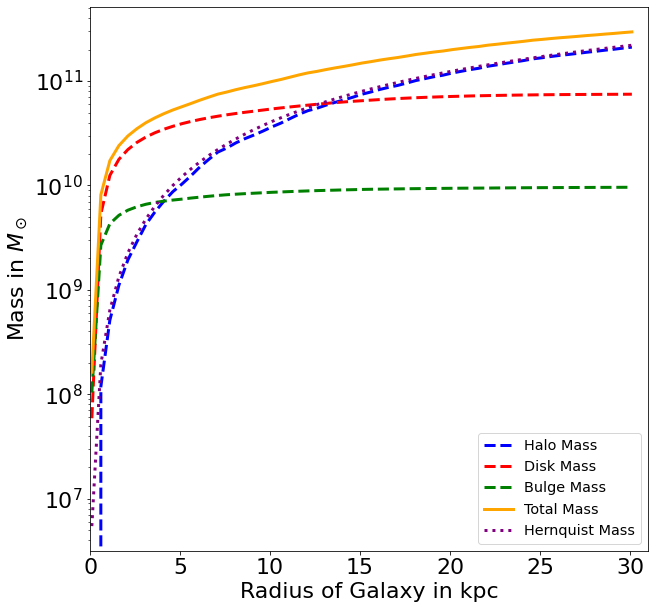

In [40]:
# Plot the Mass Profile for MW

fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

r = np.arange(0.1, 30.5, 0.5) # array for distance from Galactic center

MW = MassProfile("MW", 0) # initialize MassProfile

# plot halo mass
ax.semilogy(r, MW.MassEnclosed(1, r), color="blue", linestyle="--", 
            linewidth=3, label='Halo Mass')
# plot disk mass
ax.semilogy(r, MW.MassEnclosed(2, r), color="red", linestyle="--",
            linewidth=3, label='Disk Mass')
# plot bulge mass
ax.semilogy(r, MW.MassEnclosed(3, r), color="green", linestyle="--",
            linewidth=3, label='Bulge Mass')
# plot total mass
ax.semilogy(r, MW.MassEnclosedTotal(r), color="orange", 
            linewidth=3, label='Total Mass')
# plot hernquist mass
ax.semilogy(r, MW.HernquistMass(r*u.kpc,60*u.kpc,1.975), color="purple", 
            linestyle=":", linewidth=3, label='Hernquist Mass')

# Add labels
plt.xlabel('Radius of Galaxy in kpc', fontsize=22)
plt.ylabel(r'Mass in $M_\odot$', fontsize=22)

#set axis limits
plt.xlim(0,31)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')


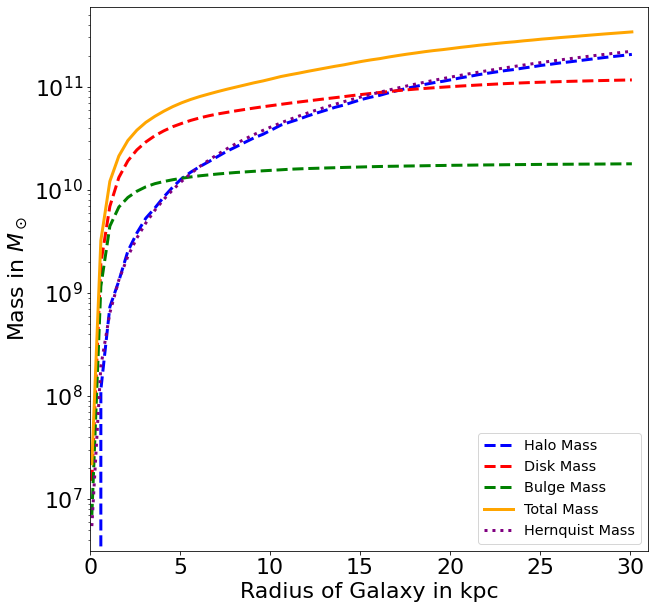

In [41]:
# PLot mass proile for M31

fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111)

M31 = MassProfile("M31", 0) # initialize MassProfile for M31

# plot halo mass
ax.semilogy(r, M31.MassEnclosed(1, r), color="blue", linestyle="--", 
            linewidth=3, label='Halo Mass')
# plot disk mass 
ax.semilogy(r, M31.MassEnclosed(2, r), color="red", linestyle="--",
            linewidth=3, label='Disk Mass')
# plot bulge mass
ax.semilogy(r, M31.MassEnclosed(3, r), color="green", linestyle="--",
            linewidth=3, label='Bulge Mass')
# plot total mass
ax.semilogy(r, M31.MassEnclosedTotal(r), color="orange", 
            linewidth=3, label='Total Mass')
# plot hernquist mass
ax.semilogy(r, M31.HernquistMass(r*u.kpc,60*u.kpc,1.975), color="purple", 
            linestyle=":", linewidth=3, label='Hernquist Mass')

# Add labels
plt.xlabel('Radius of Galaxy in kpc', fontsize=22)
plt.ylabel(r'Mass in $M_\odot$', fontsize=22)

#set axis limits
plt.xlim(0,31)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')


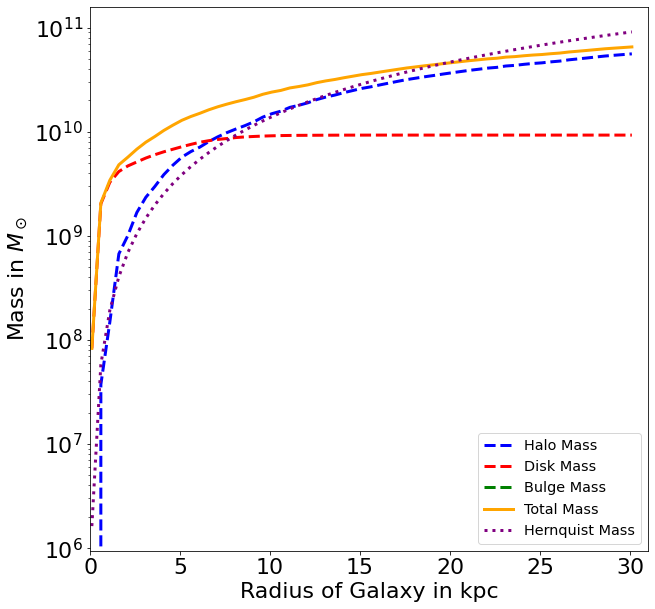

In [42]:
# Plot MassProfile of M33

fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111)

M33 = MassProfile("M33", 0) # Initialize mass profile for M33

# plot halo mass
ax.semilogy(r, M33.MassEnclosed(1, r), color="blue", linestyle="--", 
            linewidth=3, label='Halo Mass')
# plot disk mass
ax.semilogy(r, M33.MassEnclosed(2, r), color="red", linestyle="--",
            linewidth=3, label='Disk Mass')
# plot bulge mass
ax.semilogy(r, M33.MassEnclosed(3, r), color="green", linestyle="--",
            linewidth=3, label='Bulge Mass')
# plot total mass
ax.semilogy(r, M33.MassEnclosedTotal(r), color="orange", 
            linewidth=3, label='Total Mass')
# plot hernquist mass
ax.semilogy(r, M33.HernquistMass(r*u.kpc,110*u.kpc,1.975), color="purple", 
            linestyle=":", linewidth=3, label='Hernquist Mass')

# Add labels
plt.xlabel('Radius of Galaxy in kpc', fontsize=22)
plt.ylabel(r'Mass in $M_\odot$', fontsize=22)

#set axis limits
plt.xlim(0,31)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')


### Question 9

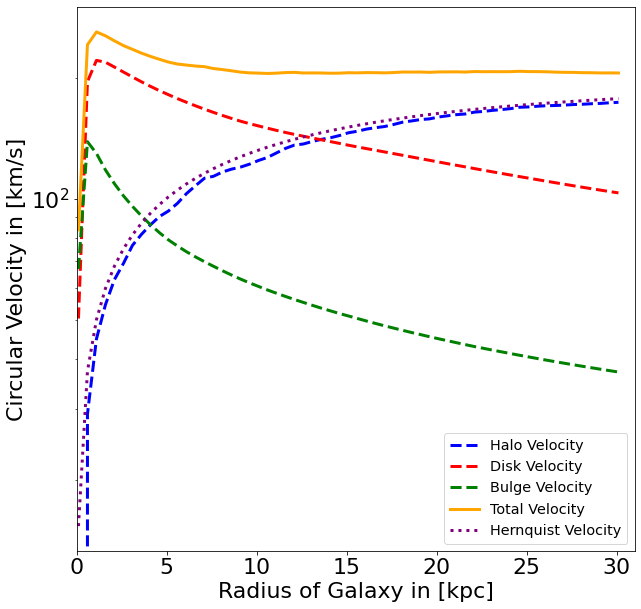

In [43]:
# Plot the Velocity Profile for MW

fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

r = np.arange(0.1, 30.5, 0.5) 

MW = MassProfile("MW", 0) 

# plot halo velocity
ax.semilogy(r, MW.CircularVelocity(1, r), color="blue", linestyle="--", 
            linewidth=3, label='Halo Velocity')
# plot disk velocity
ax.semilogy(r, MW.CircularVelocity(2, r), color="red", linestyle="--",
            linewidth=3, label='Disk Velocity')
# plot bulge velocity
ax.semilogy(r, MW.CircularVelocity(3, r), color="green", linestyle="--",
            linewidth=3, label='Bulge Velocity')
# plot total velocity
ax.semilogy(r, MW.CircularVelocityTotal(r), color="orange", 
            linewidth=3, label='Total Velocity')
# plot hernquist velocity
ax.semilogy(r, MW.HernquistVCirc(r*u.kpc,60*u.kpc,1.975), color="purple", 
            linestyle=":", linewidth=3, label='Hernquist Velocity')

# Add labels
plt.xlabel('Radius of Galaxy in [kpc]', fontsize=22)
plt.ylabel(r'Circular Velocity in [km/s]', fontsize=22)

#set axis limits
plt.xlim(0,31)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

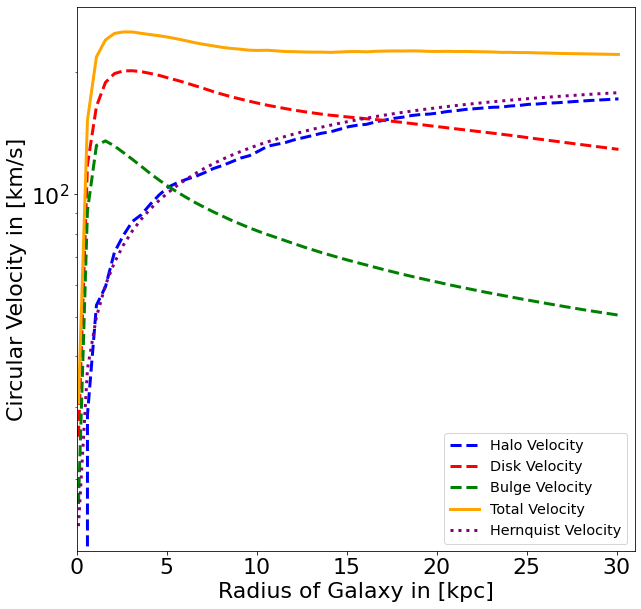

In [44]:
# Plot the Velocity Profile of M31

fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

r = np.arange(0.1, 30.5, 0.5)

M31 = MassProfile("M31", 0)

# plot halo velocity
ax.semilogy(r, M31.CircularVelocity(1, r), color="blue", linestyle="--", 
            linewidth=3, label='Halo Velocity')
# plot deisk velocity
ax.semilogy(r, M31.CircularVelocity(2, r), color="red", linestyle="--",
            linewidth=3, label='Disk Velocity')
# plot bulge  velocity
ax.semilogy(r, M31.CircularVelocity(3, r), color="green", linestyle="--",
            linewidth=3, label='Bulge Velocity')
# plot total velocity
ax.semilogy(r, M31.CircularVelocityTotal(r), color="orange", 
            linewidth=3, label='Total Velocity')
# plot hernquist velocity
ax.semilogy(r, M31.HernquistVCirc(r*u.kpc,60*u.kpc,1.975), color="purple", 
            linestyle=":", linewidth=3, label='Hernquist Velocity')

# Add labels
plt.xlabel('Radius of Galaxy in [kpc]', fontsize=22)
plt.ylabel(r'Circular Velocity in [km/s]', fontsize=22)

#set axis limits
plt.xlim(0,31)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

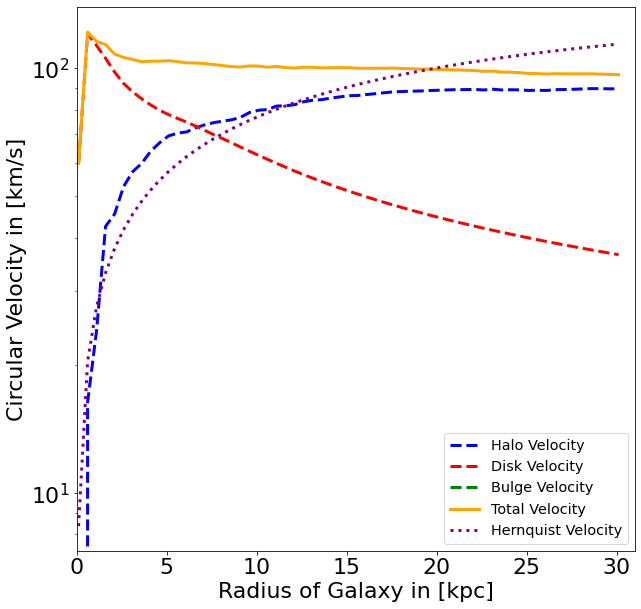

In [45]:
# Plot the Velocity Profile for M33

fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

r = np.arange(0.1, 30.5, 0.5)

M33 = MassProfile("M33", 0)

# plot halo velocity
ax.semilogy(r, M33.CircularVelocity(1, r), color="blue", linestyle="--", 
            linewidth=3, label='Halo Velocity')
# plot disk velocity
ax.semilogy(r, M33.CircularVelocity(2, r), color="red", linestyle="--",
            linewidth=3, label='Disk Velocity')
# plot bulge velocity
ax.semilogy(r, M33.CircularVelocity(3, r), color="green", linestyle="--",
            linewidth=3, label='Bulge Velocity')
# plot total velocity
ax.semilogy(r, M33.CircularVelocityTotal(r), color="orange", 
            linewidth=3, label='Total Velocity')
# plot hernquist velocity
ax.semilogy(r, M33.HernquistVCirc(r*u.kpc,110*u.kpc,1.975), color="purple", 
            linestyle=":", linewidth=3, label='Hernquist Velocity')

# Add labels
plt.xlabel('Radius of Galaxy in [kpc]', fontsize=22)
plt.ylabel(r'Circular Velocity in [km/s]', fontsize=22)

#set axis limits
plt.xlim(0,31)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')